In [1]:
import glob
import os
import random
import pandas as pd
import shutil
import numpy as np

In [4]:
annotated_files = [f for f in glob.glob("..\\full_images\\not_totally_annotated\\labels\\*.txt") if os.path.getsize(f) > 0]
#We annotated classified images. Each file should then contain at least one surfer, have at least one annotation

In [5]:
print(len(annotated_files))
annotated_files[10]

93


'..\\full_images\\not_totally_annotated\\labels\\spots_Anglet_GrandePlage_2022-03-28_08-45.txt'

In [6]:
import random
random.shuffle(annotated_files)

In [5]:
import re

def save_img_labels_to_annotated(files, folder):   
    with open('annotated\\all.txt', 'w') as f:
        for file in files:
            new_path = file.replace('not_totally_annotated\\', 'annotated\\')
            new_path = new_path.replace('labels', f'labels\\{folder}')
            if not os.path.exists(new_path):
                labels = open(file, "r").read()
                labels = np.array([[float(x) for x in row.split(" ")] for row in labels.split("\n")])
                labels[:,2] = 1 - labels[:,2]
                labels = labels.tolist()
                with open(new_path, 'w') as corrected_labels:
                    for i in range(len(labels)):
                        for j in range(4):
                            corrected_labels.write("%s " % labels[i][j])
                        corrected_labels.write("%s" % labels[i][4])
                        if i < len(labels) - 1:
                            corrected_labels.write("\n")    

                new_path_image = new_path.replace("labels", "images").replace(".txt", ".jpg")
                image = re.sub(".*?\\\\", "", file.replace(".txt",".jpg"))
                shutil.copy("..\\..\\..\\data\\surf_only_images\\" + image, new_path_image)
                f.write("%s\n" % image)      

In [48]:
from PIL import Image, ImageFile, ImageDraw
import re
import matplotlib.pyplot as plt


def display_image_in_actual_size(im, labels):
    dpi = 80
    #im_data = plt.imread(im_path)
    width, height = im.size

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
        
    # Hide spines, ticks, etc.
    ax.axis('off')    
    
    for bbox in labels:
        img_draw = ImageDraw.Draw(im)
        img_draw.rectangle(((width * bbox[1], height * bbox[2]),
                            (width * (bbox[1]+bbox[3]), height * (bbox[2]+bbox[4]))), 
                           outline='Red')

    # Display the image.
    ax.imshow(im, cmap='gray')
    plt.show()

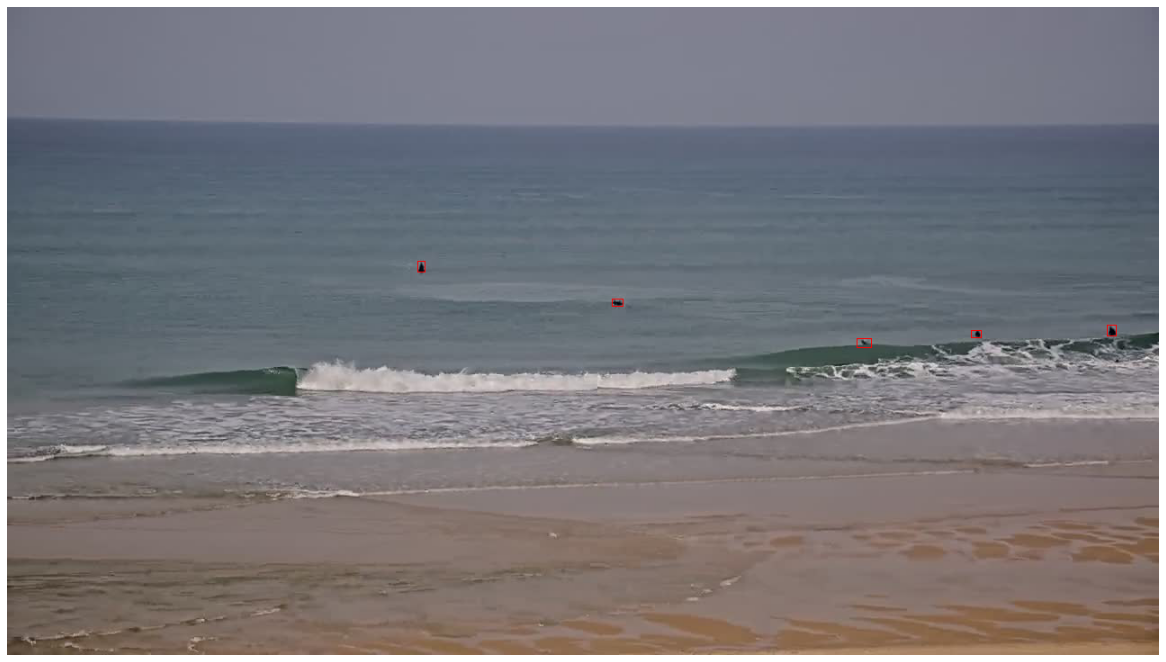

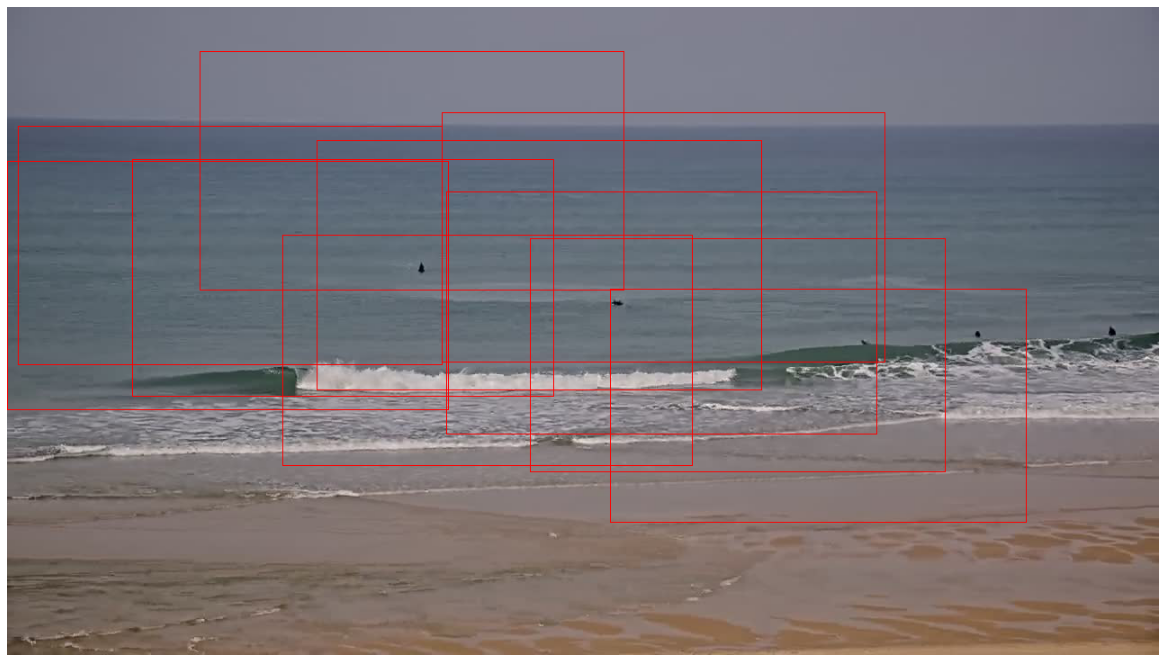

In [150]:
def random_crops(n_random_crops, min_crop_size, max_crop_size):
    crops_centers = np.random.uniform(low=min_crop_size/2, high=1 - min_crop_size/2, size=(n_random_crops,2))
    crops_sizes = np.random.uniform(low=min_crop_size, high=max_crop_size, size=(n_random_crops,1))
    crops = np.concatenate((crops_centers - crops_sizes/2, crops_sizes, crops_sizes), axis=1)
    crops = crops.clip(min=0)
    return crops


def bb_intersectionAB_over_A(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[1], boxB[0])
    yA = max(boxA[2], boxB[1])
    xB = min(boxA[1] + boxA[3], boxB[0] + boxB[2])
    yB = min(boxA[2] + boxA[4], boxB[1] + boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of A rectangle
    boxAArea = abs(boxA[3] * boxA[4])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    ioA = interArea / float(boxAArea)
    # return the intersection over A value
    return ioA


def prune_crops(crops, labels):
    new_crops = None
    for crop in crops:
        keep=False
        for label in labels:
            if bb_intersectionAB_over_A(label, crop)>0.5:
                keep = True
                break
        if keep:
            if new_crops is None:
                new_crops = [crop]
            else:
                new_crops = np.concatenate((new_crops, [crop]), axis=0)
    return new_crops

            
def split_image(image_txt_path):
    image_file = re.sub(".*?\\\\", "", image_txt_path.replace(".txt",".jpg"))
    image_path = "..\\..\\..\\data\\surf_only_images\\" + image_file
    
    labels = open(image_txt_path, "r").read()
    labels = np.array([[float(x) for x in row.split(" ")] for row in labels.split("\n")])
    labels[:,2] = 1 - labels[:,2] - labels[:,4]
    
    image = Image.open(os.path.join(image_path))
    h, w = image.size
    
    crops = random_crops(10,0.35,0.4)
    crops = prune_crops(crops, labels)
    crops = np.concatenate((crops.shape[0] * [[0]], crops),axis=1)     
    
    return image, labels, crops

image, labels, crops = split_image(annotated_files[21])
display_image_in_actual_size(image.copy(), labels)
display_image_in_actual_size(image.copy(), crops)

In [132]:
n = len(annotated_files)
i_max_train = int(n*0.6)
i_max_val = i_max_train + int(n*0.2)

In [7]:
save_img_labels_to_annotated(annotated_files[:i_max_train], 'train')
save_img_labels_to_annotated(annotated_files[i_max_train:i_max_val], 'val')
save_img_labels_to_annotated(annotated_files[i_max_val:], 'test')